In [53]:
import os
import cupy as np
import pandas as pd
from PIL import Image

# Load and preprocess dataset
input_folders = {
    0: "/kaggle/input/brain-tumors-256x256/Data/glioma_tumor",
    1: "/kaggle/input/brain-tumors-256x256/Data/meningioma_tumor",
    2: "/kaggle/input/brain-tumors-256x256/Data/normal",
    3: "/kaggle/input/brain-tumors-256x256/Data/pituitary_tumor"
}

output_csv_path = "/kaggle/working/combined_dataset.csv"
data_rows = []
for label, folder_path in input_folders.items():
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".jpg"):
            file_path = os.path.join(folder_path, file_name)
            image = Image.open(file_path).convert("L")
            image = image.resize((256, 256))
            image_array = np.array(image).flatten()
            row = [label] + image_array.tolist()
            data_rows.append(row)

columns = ["label"] + [f"pixel{i}" for i in range(256 * 256)]
dataset = pd.DataFrame(data_rows, columns=columns)
dataset.to_csv(output_csv_path, index=False)
print(f"Dataset saved to {output_csv_path}")





KeyboardInterrupt: 

In [1]:

import cupy as np
import pandas as pd

data = pd.read_csv('/kaggle/input/brain-tumor-csv/combined_dataset(4).csv')
data = np.array(data)
np.random.shuffle(data)

# Training data
m, n = data.shape
data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n] / 255.

# Small noise for generalization
noise = np.random.randn(*X_train.shape) * 0.01
X_train = X_train + noise

_, m_train = X_train.shape



In [2]:
def init_params():
    W1 = np.random.randn(1024, 65536) * np.sqrt(2/65536)
    b1 = np.zeros((1024, 1))
    W2 = np.random.randn(512, 1024) * np.sqrt(2/1024)
    b2 = np.zeros((512, 1))
    W3 = np.random.randn(4, 512) * np.sqrt(1/512)
    b3 = np.zeros((4, 1))
    return W1, b1, W2, b2, W3, b3

In [3]:
# Activation Functions
def ReLU(Z):
    return np.maximum(0.01 * Z, Z)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))  
    return expZ / np.sum(expZ, axis=0, keepdims=True)

In [4]:
def forward_prop(X, W1, b1, W2, b2, W3, b3):
    Z1 = np.dot(W1, X) + b1
    A1 = ReLU(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = ReLU(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3

In [5]:
def one_hot(Y):
    Y = Y.astype(int)
    one_hot_Y = np.zeros((4, Y.size))
    one_hot_Y[Y, np.arange(Y.size)] = 1
    return one_hot_Y

def ReLU_deriv(Z):
    return Z > 0

def backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y):
    one_hot_Y = one_hot(Y)
    dZ3 = A3 - one_hot_Y
    dW3 = (1 / m_train) * np.dot(dZ3, A2.T)
    db3 = (1 / m_train) * np.sum(dZ3, axis=1, keepdims=True)
    dZ2 = np.dot(W3.T, dZ3) * (Z2 > 0)
    dW2 = (1 / m_train) * np.dot(dZ2, A1.T)
    db2 = (1 / m_train) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * (Z1 > 0)
    dW1 = (1 / m_train) * np.dot(dZ1, X.T)
    db1 = (1 / m_train) * np.sum(dZ1, axis=1, keepdims=True)
    return dW1, db1, dW2, db2, dW3, db3
    

In [6]:
def save_model(filename, W1, b1, W2, b2, W3, b3):
    np.savez(filename, W1=W1, b1=b1, W2=W2, b2=b2, W3=W3, b3=b3)
    print(f"Model saved to {filename}")

In [7]:
alpha = 0.02

def gradient_descent(X, Y, iterations):
    W1, b1, W2, b2, W3, b3 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(X, W1, b1, W2, b2, W3, b3)
        dW1, db1, dW2, db2, dW3, db3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, Y)
        W1 -= alpha * dW1
        b1 -= alpha * db1
        W2 -= alpha * dW2
        b2 -= alpha * db2
        W3 -= alpha * dW3
        b3 -= alpha * db3
        if i % 10 == 0:
            predictions = np.argmax(A3, axis=0)
            accuracy = np.mean(predictions == Y)
            print(f"Iteration {i}, Accuracy: {accuracy:.4f}")
    return W1, b1, W2, b2, W3, b3
    


In [8]:
from matplotlib import pyplot as plt

def load_model(filename):
    data = np.load(filename)
    W1, b1 = data["W1"], data["b1"]
    W2, b2 = data["W2"], data["b2"]
    W3, b3 = data["W3"], data["b3"]
    print(f"Model loaded from {filename}")
    return W1, b1, W2, b2, W3, b3


def get_predictions(A3):
    return np.argmax(A3, 0)


def make_predictions(X, W1, b1, W2, b2, W3, b3):
    _, _, _, _, _, A3 = forward_prop(X, W1, b1, W2, b2, W3, b3)
    return get_predictions(A3)
    
def test_prediction(index, W1, b1, W2, b2, W3, b3):
    current_image = X_train[:, index:index+1]
    prediction = make_predictions(current_image, W1, b1, W2, b2, W3, b3)
    label = Y_train[index].item()
    print(f"Prediction: {prediction.item()}, Label: {label}")
    current_image = current_image.reshape(256, 256) * 255
    plt.gray()
    plt.imshow(current_image.get(), interpolation='nearest')
    plt.show()

In [9]:

W1, b1, W2, b2, W3, b3 = gradient_descent(X_train, Y_train, iterations=1000)


Iteration 0, Accuracy: 0.1994
Iteration 10, Accuracy: 0.4327
Iteration 20, Accuracy: 0.3989
Iteration 30, Accuracy: 0.4885
Iteration 40, Accuracy: 0.5243
Iteration 50, Accuracy: 0.5802
Iteration 60, Accuracy: 0.5157
Iteration 70, Accuracy: 0.5286
Iteration 80, Accuracy: 0.3259
Iteration 90, Accuracy: 0.5802
Iteration 100, Accuracy: 0.6026
Iteration 110, Accuracy: 0.6431
Iteration 120, Accuracy: 0.6279
Iteration 130, Accuracy: 0.7094
Iteration 140, Accuracy: 0.6155
Iteration 150, Accuracy: 0.5964
Iteration 160, Accuracy: 0.6250
Iteration 170, Accuracy: 0.6703
Iteration 180, Accuracy: 0.7910
Iteration 190, Accuracy: 0.7500
Iteration 200, Accuracy: 0.6775
Iteration 210, Accuracy: 0.7290
Iteration 220, Accuracy: 0.7276
Iteration 230, Accuracy: 0.7032
Iteration 240, Accuracy: 0.8287
Iteration 250, Accuracy: 0.8607
Iteration 260, Accuracy: 0.6994
Iteration 270, Accuracy: 0.7848
Iteration 280, Accuracy: 0.8483
Iteration 290, Accuracy: 0.8545
Iteration 300, Accuracy: 0.8125
Iteration 310, Accu

In [10]:
save_model('best_model', W1, b1, W2, b2, W3, b3)

Model saved to best_model


In [23]:
save_model('best_model', W1, b1, W2, b2, W3, b3)

Model saved to best_model


In [11]:
W1, b1, W2, b2, W3, b3 = load_model('best_model.npz')

Model loaded from best_model.npz


Prediction: 2, Label: 2


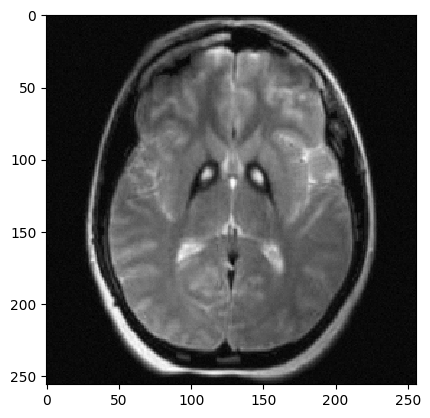

Prediction: 0, Label: 0


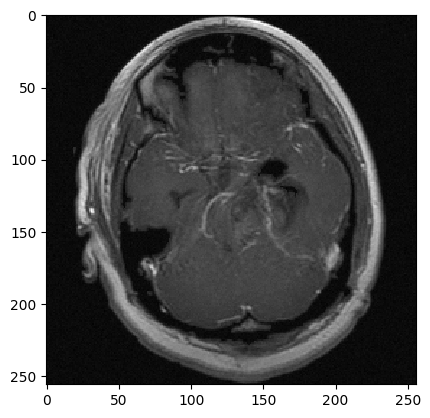

Prediction: 1, Label: 1


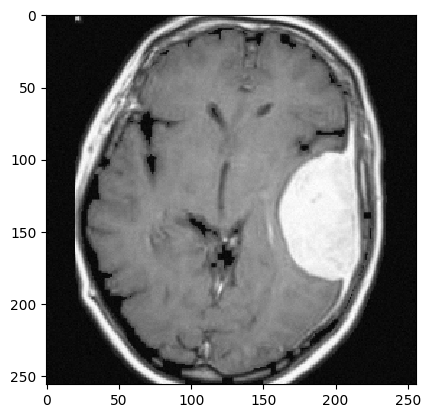

Prediction: 1, Label: 1


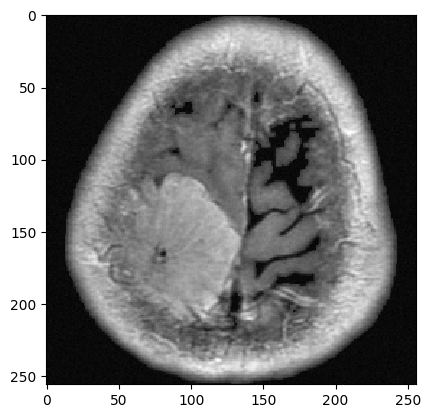

Prediction: 0, Label: 0


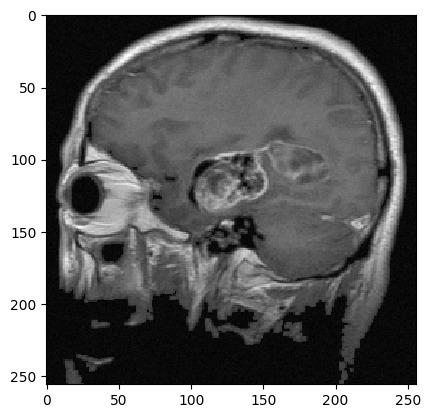

Prediction: 3, Label: 3


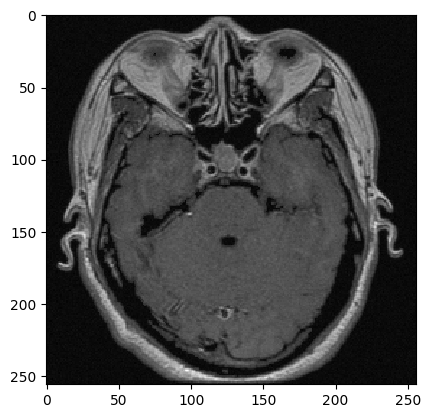

Prediction: 0, Label: 0


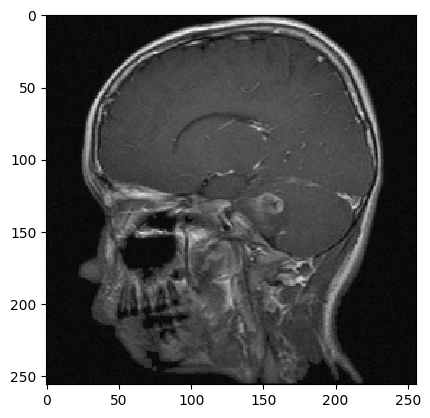

Prediction: 0, Label: 0


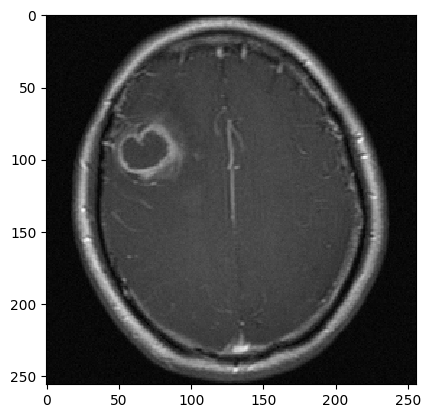

In [12]:


test_prediction(0, W1, b1, W2, b2, W3, b3)
test_prediction(1, W1, b1, W2, b2, W3, b3)
test_prediction(2, W1, b1, W2, b2, W3, b3)
test_prediction(3, W1, b1, W2, b2, W3, b3)
test_prediction(4, W1, b1, W2, b2, W3, b3)
test_prediction(5, W1, b1, W2, b2, W3, b3)
test_prediction(6, W1, b1, W2, b2, W3, b3)
test_prediction(7, W1, b1, W2, b2, W3, b3)